In [156]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
import string
import us
from geopy.geocoders import Nominatim
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNetCV
import math

In [157]:
df = pd.read_csv("df_new_draft.csv")
df.head(5)

,Unnamed: 0,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,...,wi_count,dc_count,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count
0,0,1782,NaN,173.108454,NaN,NaN,55.768842,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1784,NaN,173.063703,NaN,NaN,56.035361,NaN,NaN,9.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1787,NaN,172.974200,NaN,NaN,NaN,NaN,NaN,20.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1788,NaN,172.929448,NaN,NaN,56.126853,NaN,NaN,3.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1791,26.45349,172.892156,NaN,NaN,56.063206,0.532692,1.146261,1.0,...,0,0,0,0,0,0,0,0,0,0


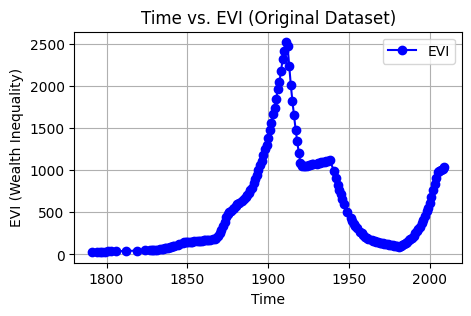

In [159]:
def plot(df, target_column):
    """
    Plots a simple line graph of Time vs. target column using the original dataset (before imputation).
    
    Parameters:
    - df: Original dataset.
    - target_column: The varaible that will be imputed
    """
    plt.figure(figsize=(5, 3))

    # Plot Time vs. EVI
    plt.plot(df['Year'], df[target_column], marker='o', linestyle='-', color='b', label="EVI")

    plt.xlabel("Time")
    plt.ylabel("EVI (Wealth Inequality)")
    plt.title("Time vs. EVI (Original Dataset)")
    plt.legend()
    plt.grid(True)

    plt.show()

plot(df, "EVI")


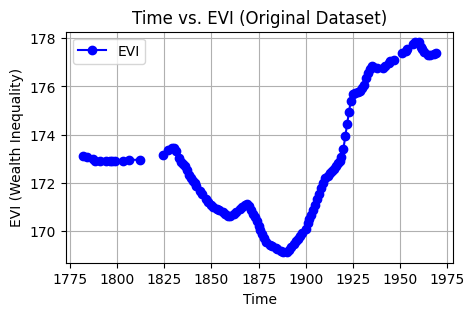

In [160]:
plot(df, "Height")

In [161]:
columns_to_scale = [ 'Year', 'EVI','Height','HSUS','Immigration','Life Expectancy','Polarization','Wage GDP Ratio','fatalities']
df_filtered = df[columns_to_scale]
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), columns=columns_to_scale)
correlation_matrix = df_scaled.corr()
correlation_matrix
# target_column = "EVI"  
# print(f"Missing values in {target_column}: {new_df[target_column].isna().sum()}")

,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities
Year,1.000000,0.174608,0.535084,0.663973,-0.129443,0.452747,0.144200,-0.794802,-0.049360
EVI,0.174608,1.000000,-0.061585,0.475517,0.620288,-0.004355,0.606042,-0.517672,-0.020495
Height,0.535084,-0.061585,1.000000,0.565268,-0.558372,0.884534,-0.601059,-0.044354,-0.152852
HSUS,0.663973,0.475517,0.565268,1.000000,0.157297,0.526706,0.182581,-0.656354,-0.069002
Immigration,-0.129443,0.620288,-0.558372,0.157297,1.000000,-0.416478,0.790279,-0.430035,0.233389
Life Expectancy,0.452747,-0.004355,0.884534,0.526706,-0.416478,1.000000,-0.419371,-0.183245,-0.140176
Polarization,0.144200,0.606042,-0.601059,0.182581,0.790279,-0.419371,1.000000,-0.591504,0.071414
Wage GDP Ratio,-0.794802,-0.517672,-0.044354,-0.656354,-0.430035,-0.183245,-0.591504,1.000000,-0.045628
fatalities,-0.049360,-0.020495,-0.152852,-0.069002,0.233389,-0.140176,0.071414,-0.045628,1.000000


In [162]:
def impute_boosting(df, target_column, time_column, f_1, f_2, model_type="gradient_boosting"):
    """
    Impute only the missing values in the EVI column using Gradient Boosting or AdaBoost regression with cross-validation.
    Existing EVI values remain unchanged.
    
    Parameters:
    - df: DataFrame containing the data.
    - target_column: The column to impute.
    - time_column: A column serving as a time index.
    - model_type: Choose "gradient_boosting" or "adaboost".
    """
    df_imputed = df.copy()

    # Select features (including time)
    feature_columns = [f_1, f_2, time_column]

    # Identify missing values in target
    missing_mask = df_imputed[target_column].isna()

    # Split into training (non-missing target values) and prediction (missing target values)
    train_data = df_imputed[~missing_mask]  # Use only rows where EVI is present for training
    predict_data = df_imputed[missing_mask]  # Use only missing EVI rows for prediction

    if predict_data.empty:
        print(f"No missing values in {target_column}.")
        return df

    # Define X (features) and y (target)
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_pred = predict_data[feature_columns]  # Use only the rows where EVI is missing

    # Handle missing values in predictors using KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_columns, index=X_train.index)
    X_pred = pd.DataFrame(imputer.transform(X_pred), columns=feature_columns, index=X_pred.index)

    # Standardize Features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_columns, index=X_train.index)
    X_pred = pd.DataFrame(scaler.transform(X_pred), columns=feature_columns, index=X_pred.index)

    # Ensure alignment between X_train and y_train
    valid_rows = X_train.index
    y_train = y_train.loc[valid_rows]

    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of X_pred: {X_pred.shape}")

    if X_train.empty or y_train.empty:
        print(f"Not enough data to train for {target_column}. Returning original dataset.")
        return df

    # **Choose Boosting Model**
    if model_type == "gradient_boosting":
        model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=25)
    elif model_type == "adaboost":
        model = AdaBoostRegressor(n_estimators=300, learning_rate=0.1, random_state=25)
    else:
        print("Invalid model_type! Choose 'gradient_boosting' or 'adaboost'.")
        return df

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring="neg_mean_squared_error")
    print(f"Cross-validation MSE for {target_column} using {model_type}: {-scores.mean()}")

    model.fit(X_train, y_train)

    # Predict missing values **only**
    predicted_values = model.predict(X_pred)

    # Ensure length matches before filling in missing values
    if len(predicted_values) != missing_mask.sum():
        print("Warning: Mismatch between predicted values and missing entries. Adjusting size.")
        df_imputed.loc[missing_mask, target_column] = np.nan
    else:
        df_imputed.loc[missing_mask, target_column] = predicted_values  # **Only update missing values**
    return df_imputed

In [169]:
df_imputed_gb = impute_boosting(df, "EVI", "Unnamed: 0", 'Immigration', "Polarization", model_type="gradient_boosting")
print(f"Missing values before imputation in {'EVI'}: {df['EVI'].isna().sum()}")
df_imputed_gb.head(10)

Shape of X_train: (181, 3)
Shape of y_train: (181,)
Shape of X_pred: (12, 3)
Cross-validation MSE for EVI using gradient_boosting: 286443.62163091707
Missing values before imputation in EVI: 12


,Unnamed: 0,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,...,wi_count,dc_count,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count
0,0,1782,25.278620,173.108454,NaN,NaN,55.768842,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1784,25.278620,173.063703,NaN,NaN,56.035361,NaN,NaN,9.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1787,25.278620,172.974200,NaN,NaN,NaN,NaN,NaN,20.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1788,25.278620,172.929448,NaN,NaN,56.126853,NaN,NaN,3.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1791,26.453490,172.892156,NaN,NaN,56.063206,0.532692,1.146261,1.0,...,0,0,0,0,0,0,0,0,0,0
5,5,1794,28.337294,172.892156,NaN,NaN,55.818565,0.590043,0.976730,7.0,...,0,0,0,0,0,0,0,0,0,0
6,6,1796,30.371957,172.892156,NaN,NaN,55.655471,0.642230,0.987561,1.0,...,0,0,0,0,0,0,0,0,0,0
7,7,1797,31.426136,172.892156,NaN,NaN,55.518234,0.683133,1.086310,1.0,...,0,0,0,0,0,0,0,0,0,1
8,8,1799,33.705873,172.892156,18.535534,NaN,55.188864,0.691328,0.894909,1.0,...,0,0,0,0,0,0,0,0,0,0
9,9,1801,36.101047,NaN,18.743845,NaN,54.893703,0.683123,1.180416,1.0,...,0,0,0,0,0,0,0,0,0,0


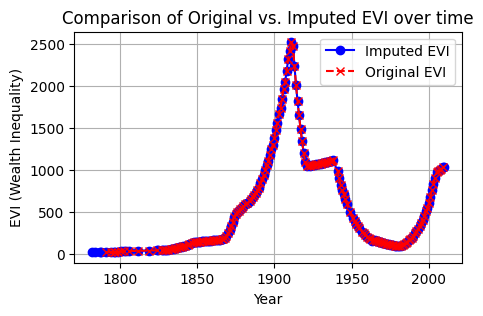

In [177]:
def imputed_vs_original(df_original, df_imputed, time_column, target_column):
    """
    Plots all values in the EVI column of the imputed dataset against year and 
    overlays the original EVI values against year on the same graph.

    Parameters:
    - df_original: Original dataset (before imputation).
    - df_imputed: Dataset after imputation.
    - time_column: Column representing the year
    """
    plt.figure(figsize=(5, 3))

    plt.plot(df_imputed[time_column], df_imputed[target_column], 
             marker='o', linestyle='-', color='blue', label="Imputed EVI")

    plt.plot(df[time_column], df[target_column], 
             marker='x', linestyle='--', color='red', label="Original EVI")

    # Labels and title
    plt.xlabel("Year")
    plt.ylabel("EVI (Wealth Inequality)")
    plt.title(f"Comparison of Original vs. Imputed {target_column} over time")
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Call function with original and imputed dataset
imputed_vs_original(df, df_imputed_gb, "Year", "EVI")


In [178]:
# Running model to imputate 'height'
df_imputed_gb = impute_boosting(df_imputed_gb, "Height", "Unnamed: 0", 'Life Expectancy', "Polarization", model_type="gradient_boosting")
print(f"Missing values before imputation in {'Height'}: {df['Height'].isna().sum()}")
df_imputed_gb.head(10)

No missing values in Height.
Missing values before imputation in Height: 70


,Unnamed: 0,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,...,wi_count,dc_count,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count
0,0,1782,25.278620,173.108454,19.258893,NaN,55.768842,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1784,25.278620,173.063703,19.004489,NaN,56.035361,NaN,NaN,9.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1787,25.278620,172.974200,19.098354,NaN,NaN,NaN,NaN,20.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1788,25.278620,172.929448,18.675441,NaN,56.126853,NaN,NaN,3.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1791,26.453490,172.892156,18.544447,NaN,56.063206,0.532692,1.146261,1.0,...,0,0,0,0,0,0,0,0,0,0
5,5,1794,28.337294,172.892156,18.551281,NaN,55.818565,0.590043,0.976730,7.0,...,0,0,0,0,0,0,0,0,0,0
6,6,1796,30.371957,172.892156,18.551281,NaN,55.655471,0.642230,0.987561,1.0,...,0,0,0,0,0,0,0,0,0,0
7,7,1797,31.426136,172.892156,18.535329,NaN,55.518234,0.683133,1.086310,1.0,...,0,0,0,0,0,0,0,0,0,1
8,8,1799,33.705873,172.892156,18.535534,NaN,55.188864,0.691328,0.894909,1.0,...,0,0,0,0,0,0,0,0,0,0
9,9,1801,36.101047,172.892396,18.743845,NaN,54.893703,0.683123,1.180416,1.0,...,0,0,0,0,0,0,0,0,0,0


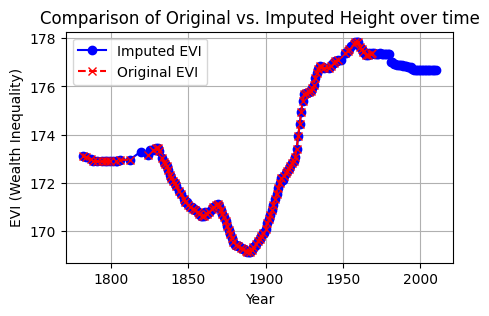

In [179]:
imputed_vs_original(df, df_imputed_gb, "Year", "Height")

In [180]:
# Running model to imputate 'HSUS'
df_imputed_gb = impute_boosting(df_imputed_gb, "HSUS", "Unnamed: 0", 'Life Expectancy', "Height", model_type="gradient_boosting")
print(f"Missing values before imputation in {'HSUS'}: {df['HSUS'].isna().sum()}")
df_imputed_gb.head(10)

No missing values in HSUS.
Missing values before imputation in HSUS: 53


,Unnamed: 0,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,...,wi_count,dc_count,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count
0,0,1782,25.278620,173.108454,19.258893,NaN,55.768842,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1784,25.278620,173.063703,19.004489,NaN,56.035361,NaN,NaN,9.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1787,25.278620,172.974200,19.098354,NaN,NaN,NaN,NaN,20.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1788,25.278620,172.929448,18.675441,NaN,56.126853,NaN,NaN,3.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1791,26.453490,172.892156,18.544447,NaN,56.063206,0.532692,1.146261,1.0,...,0,0,0,0,0,0,0,0,0,0
5,5,1794,28.337294,172.892156,18.551281,NaN,55.818565,0.590043,0.976730,7.0,...,0,0,0,0,0,0,0,0,0,0
6,6,1796,30.371957,172.892156,18.551281,NaN,55.655471,0.642230,0.987561,1.0,...,0,0,0,0,0,0,0,0,0,0
7,7,1797,31.426136,172.892156,18.535329,NaN,55.518234,0.683133,1.086310,1.0,...,0,0,0,0,0,0,0,0,0,1
8,8,1799,33.705873,172.892156,18.535534,NaN,55.188864,0.691328,0.894909,1.0,...,0,0,0,0,0,0,0,0,0,0
9,9,1801,36.101047,172.892396,18.743845,NaN,54.893703,0.683123,1.180416,1.0,...,0,0,0,0,0,0,0,0,0,0


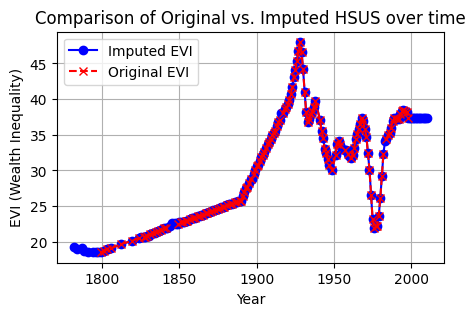

In [181]:
imputed_vs_original(df, df_imputed_gb, "Year", "HSUS")

In [183]:
# Running model to imputate 'Immigration'
df_imputed_gb = impute_boosting(df_imputed_gb, "Immigration", "Unnamed: 0", 'EVI', "Polarization", model_type="gradient_boosting")
print(f"Missing values before imputation in {'HSUS'}: {df['HSUS'].isna().sum()}")
df_imputed_gb.head(10)

Shape of X_train: (173, 3)
Shape of y_train: (173,)
Shape of X_pred: (20, 3)
Cross-validation MSE for Immigration using gradient_boosting: 17.189737262408617
Missing values before imputation in HSUS: 53


,Unnamed: 0,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,...,wi_count,dc_count,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count
0,0,1782,25.278620,173.108454,19.258893,1.496999,55.768842,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1784,25.278620,173.063703,19.004489,1.496999,56.035361,NaN,NaN,9.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1787,25.278620,172.974200,19.098354,1.496999,NaN,NaN,NaN,20.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1788,25.278620,172.929448,18.675441,1.496999,56.126853,NaN,NaN,3.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1791,26.453490,172.892156,18.544447,1.566766,56.063206,0.532692,1.146261,1.0,...,0,0,0,0,0,0,0,0,0,0
5,5,1794,28.337294,172.892156,18.551281,6.839692,55.818565,0.590043,0.976730,7.0,...,0,0,0,0,0,0,0,0,0,0
6,6,1796,30.371957,172.892156,18.551281,8.341955,55.655471,0.642230,0.987561,1.0,...,0,0,0,0,0,0,0,0,0,0
7,7,1797,31.426136,172.892156,18.535329,8.394216,55.518234,0.683133,1.086310,1.0,...,0,0,0,0,0,0,0,0,0,1
8,8,1799,33.705873,172.892156,18.535534,8.393999,55.188864,0.691328,0.894909,1.0,...,0,0,0,0,0,0,0,0,0,0
9,9,1801,36.101047,172.892396,18.743845,8.394216,54.893703,0.683123,1.180416,1.0,...,0,0,0,0,0,0,0,0,0,0


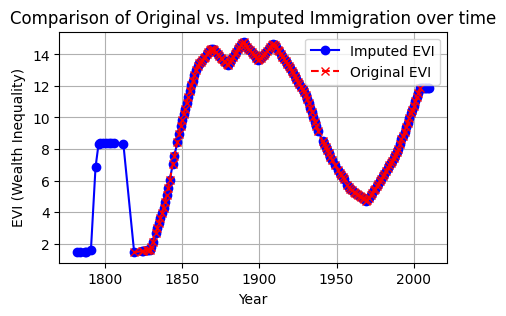

In [184]:
imputed_vs_original(df, df_imputed_gb, "Year", "Immigration")

In [186]:
# Running model to imputate 'Life Expectancy'
df_imputed_gb = impute_boosting(df_imputed_gb, "Life Expectancy", "Unnamed: 0", 'Height', "HSUS", model_type="gradient_boosting")
print(f"Missing values before imputation in {'Life Expectancy'}: {df['HSUS'].isna().sum()}")
df_imputed_gb.head(10)

Shape of X_train: (111, 3)
Shape of y_train: (111,)
Shape of X_pred: (82, 3)
Cross-validation MSE for Life Expectancy using gradient_boosting: 11.302889618569083
Missing values before imputation in Life Expectancy: 53


,Unnamed: 0,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,...,wi_count,dc_count,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count
0,0,1782,25.278620,173.108454,19.258893,1.496999,55.768842,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1784,25.278620,173.063703,19.004489,1.496999,56.035361,NaN,NaN,9.0,...,0,0,0,0,0,0,0,0,0,0
2,2,1787,25.278620,172.974200,19.098354,1.496999,56.071185,NaN,NaN,20.0,...,0,0,0,0,0,0,0,0,0,0
3,3,1788,25.278620,172.929448,18.675441,1.496999,56.126853,NaN,NaN,3.0,...,0,0,0,0,0,0,0,0,0,0
4,4,1791,26.453490,172.892156,18.544447,1.566766,56.063206,0.532692,1.146261,1.0,...,0,0,0,0,0,0,0,0,0,0
5,5,1794,28.337294,172.892156,18.551281,6.839692,55.818565,0.590043,0.976730,7.0,...,0,0,0,0,0,0,0,0,0,0
6,6,1796,30.371957,172.892156,18.551281,8.341955,55.655471,0.642230,0.987561,1.0,...,0,0,0,0,0,0,0,0,0,0
7,7,1797,31.426136,172.892156,18.535329,8.394216,55.518234,0.683133,1.086310,1.0,...,0,0,0,0,0,0,0,0,0,1
8,8,1799,33.705873,172.892156,18.535534,8.393999,55.188864,0.691328,0.894909,1.0,...,0,0,0,0,0,0,0,0,0,0
9,9,1801,36.101047,172.892396,18.743845,8.394216,54.893703,0.683123,1.180416,1.0,...,0,0,0,0,0,0,0,0,0,0


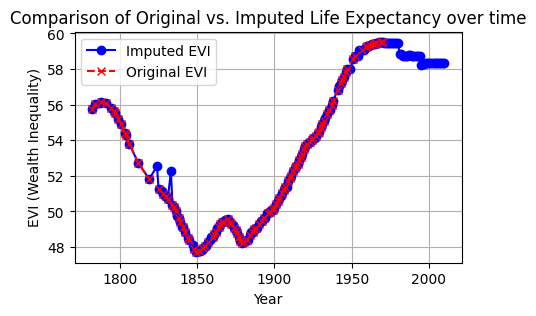

In [188]:
imputed_vs_original(df, df_imputed_gb, "Year", "Life Expectancy")